# Basic implementation of DAISY descriptor

## DAISY Algorithm
DAISY samples the local gradient information as shown in a figure below. Each circle represents a region where the radius is proportional to the standard deviations of the Gaussian kernels. Dots represents locations where the Convolved Orientation Maps (COMs) are sampled.

<img src="DAISY-descriptor-structure.png" style="width: 300px;">

Each circle represents one histogram region, which is part of the descriptor vector. Each histogram represents the Gradient Orientations (GOs) within this region. The gradient is split into $H$ discrete orientations, so each single histogram has $H$ entries.

Algortihm uses $Q$ rings around the central point, on which the COMs are sampled, each ring has $T$ histograms.

Therefore, each descriptor has $D_s=(Q \centerdot T+1)\centerdot H$ entries.

To compute GOs at a specified point $(u,v)$, several oriented derivatives of image $I$ are computed as following:

$$G_o^\sigma = G^\sigma * \left(\dfrac{dI}{do}\right)^+ , \left(\dfrac{dI}{do}\right)^+ = max\left(\dfrac{dI}{do}, 0\right),$$
where $ G^\sigma $ is a Gaussian kernel with standard deviation $ \sigma $ and $o$ is a derivative orientation.

The results $G_o^{\sigma}$ are referred as Convolved Orientation Maps (COMs).

In the next step the vector $h_\sigma(u,v)$ is being built as following:

$$h_\sigma(u,v) = \left[G_1^\sigma(u,v), \dots, G_H^\sigma(u,v)\right]^T$$

Vector $h(u,v)$ is then normalized to unit norm. It represents the values of all the GOs at a point $(u,v)$ after convolution with a Gaussian kernel with a standard deviation $\sigma$.

The full DAISY descriptor for location $(u_0,v_0)$ is defined as a simple concatenation of all the vectors $h_{\sigma i}(u,v)$ for all points beginning with the center:

$$D(u_0,v_0) = [h_{\sigma 1}(u_0, v_0), h_{\sigma 1}(I_1(u_0, v_0, R_1)), \dots, h_{\sigma 1}(I_T(u_0, v_0, R_1),$$ 
$$h_{\sigma 2}(I_1(u_0, v_0, R_2)), \dots, h_{\sigma 2}(I_T(u_0, v_0, R_2),$$
$$\dots \dots$$
$$h_{\sigma Q}(I_1(u_0, v_0, R_Q)), \dots, h_{\sigma Q}(I_T(u_0, v_0, R_Q)],$$

where $I_j(u, v, R)$ is the location with distance $R$ from $(u, v)$ in the direction given by $j$
when the directions are quantized into the $T$ values.

In [13]:
import numpy as np

from skimage import data
from skimage.color import rgb2gray
from skimage.filters import sobel_h, sobel_v, gaussian
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sb


from skimage.draw import (line, circle_perimeter)

%matplotlib notebook 
%rehashx

## DAISY implementation
Next function computes a single Gradient Orientation Map. As image derivative we use a Sobel filter.
Standard edge-detection filter can work only in $x$ or $y$ axis.
However, method, known as steerable filter, allows us to compute derivative at any virtual axis $z$ at some angle $\theta$:
$$d_z = \left(d_x \cos\theta + d_y \sin\theta\right)^+$$

In [14]:
# Computes a Gradient Orientation Map on derivative axis
# with angle tetha
def gradient_orientation(image, tetha):
    # Steering filter - combination of X and Y derivatives 
    # to det a derivative on a specific angle
    d_hor = sobel_h(image)
    d_ver = sobel_v(image)
    derivative = d_hor * np.cos(tetha) + d_ver * np.sin(tetha)
    # Operator max(d, 0) is already built in a Sobel filter in skimage
    return derivative

Next function computes a set of GO's for a given number of directions. Directions are arranged evenly in a circle.

In [15]:
# Compute GOs for a number of directions
def compute_global_orientation_maps(image, H):
    tetha_step = 2 * np.pi / H
    result = []
    for k in range(0, H):
        tetha = tetha_step * k
        result.append(gradient_orientation(image, tetha))
    return result

Next function convolves a set of GO's with several Gaussian kernels to produce Convolved Orientation Maps for each level of Gaussian standard deviation $\sigma$.

In [16]:
# Convolves orientation maps with Gaussian
# kernels with specified standard deviations
def convolve_orientation_maps(gos, sigmas):
    result = []
    for sigma in sigmas:
        conv = []
        for go in gos:
            conv.append(gaussian(go, sigma))
        result.append(conv)
    return result

Here is the main DAISY function. For illustrative purposes, we compute only one descriptor, at the center of the image. Function returns descriptor vector $Ds$, visualization of a DAISY pattern, and a set of computed COM's to illustrate it's work.

In [17]:
# Implemetation of DAISY with a single descriptor for
# a center point of the image
def daisy(image, R, Q, T, H, sigmas):
    
    # Setting steps in angle and radius
    tetha_step = 2 * np.pi / T
    radius_step = float(R) / Q
    # Calculating total number of entries in a descriptor
    Ds = (Q*T+1)*H
    descriptor = np.zeros((1, Ds))
    # Center point
    x, y = image.shape
    center = [int(x/2), int(y/2)]
    
    # Copy of image for visualization
    visualize = np.copy(image)
    
    # Compute GOs
    gradient_orientations = compute_global_orientation_maps(image, H)
    # Convolve GOs with Gaussian kernels to get COMs
    conv_orient_maps = convolve_orientation_maps(gradient_orientations, sigmas)
    
    # Sampling vectors from COMs at DAISY points
    # Center point
    h = sample_h_vector(center[0], center[1], conv_orient_maps[0], visualize, sigmas[0])
    descriptor[0, 0:H] = h
    # Sample the rest of the points in DAISY pattern
    for i in range(0, Q):
        r = (i+1) * radius_step
        maps = conv_orient_maps[i]
        for j in range(0, T):
            tetha = j * tetha_step
            x = int(center[0] + r * np.cos(tetha))
            y = int(center[1] + r * np.sin(tetha))
            
            h = sample_h_vector(x, y, maps, visualize, sigmas[i+1])
            idx_start = ((i)*T+j)*H+H
            idx_end = ((i)*T+j)*H+2*H
            descriptor[0, idx_start:idx_end] = h
            
    return descriptor, visualize, gradient_orientations, conv_orient_maps

# Samples the single h vector at point 
def sample_h_vector(x, y, maps, visualize, sigma):
    # Sampling the vector
    h = np.zeros(H)
    for k in range(0, H):
        h[k] = maps[k][x, y]
    # Normalization
    h = preprocessing.normalize(h.reshape((1, -1)), norm='l2')
    # Visualize the point
    draw_circle(visualize, x, y, sigma)
    draw_lines(visualize, x, y, sigma, H)
    return h

#### Utility functions
Functions for data visualization

In [28]:
# Draws a circle
def draw_circle(image, x, y, radius):
    rr, cc = circle_perimeter(x, y, radius)
    image[rr, cc] = 255

# Draws a set of evenly arranged lines from center
def draw_lines(image, x, y, radius, n):
    tetha_step = 2 * np.pi / n
    for i in range(0, n):
        tetha = i * tetha_step
        line_len = int(radius * 0.7)
        x1 = int(x + line_len * np.sin(tetha))
        j1 = int(y + line_len * np.cos(tetha))
        rr, cc = line(x, y, x1, j1)
        image[rr, cc] = 255
    
# Shows an image
def imgshow(image, title='', cmap=plt.cm.gray):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap=cmap)
    ax.set_title(title)
    plt.show()

# Shows a set of images in a grid 
def show_maps(maps, title=''):
    grid_i = 2
    grid_j = int(np.floor(len(maps) / 2))
    fig, ax = plt.subplots(grid_i, grid_j)
    fig.suptitle(title)
    for i in range(0, grid_i):
        for j in range(0, grid_j):
            idx = i*grid_i+j
            if(idx >= len(maps)):
                break
            ax[i, j].imshow(maps[idx], cmap = plt.cm.gnuplot2)

## Test data preparation
We use a 128 * 128 sample of a contrast grayscale image from skimage.data

<IPython.core.display.Javascript object>


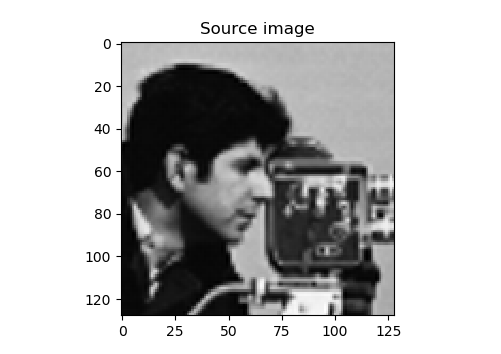

Image size:(128, 128)


In [19]:
img_src = data.camera()

center = [128, 256]
size = [128, 128]

image = img_src[int(center[0]-size[0] / 2):int(center[0]+size[0] / 2), 
           int(center[1]-size[1] / 2):int(center[1]+size[1] / 2)]
imgshow(image, 'Source image')
print(f'Image size:{image.shape}')

## Testing section 
Here is the list of modifiable parameters:
* Maximum radius $R$
* Number of rings $Q$
* Number of points per ring $T$
* Number of histograms per point $H$
* Gaussian filter standard deviations $\sigma$ for each ring

**Notice that big sigma values or radius may result in index out of bounds exception!** 

In [35]:
R = 32
Q = 2
T = 8
H = 8
SIGMAS = [10, 10, 25]

<IPython.core.display.Javascript object>


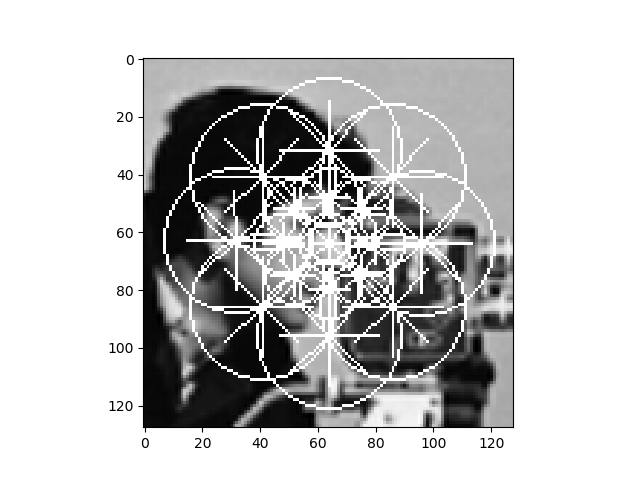

In [37]:
descriptor, visualize, gradient_orientations, coms = daisy(image, R, Q, T, H, SIGMAS)
imgshow(visualize)

Here we can explore the algorithm data. Let's check gradient orientation maps:

<IPython.core.display.Javascript object>


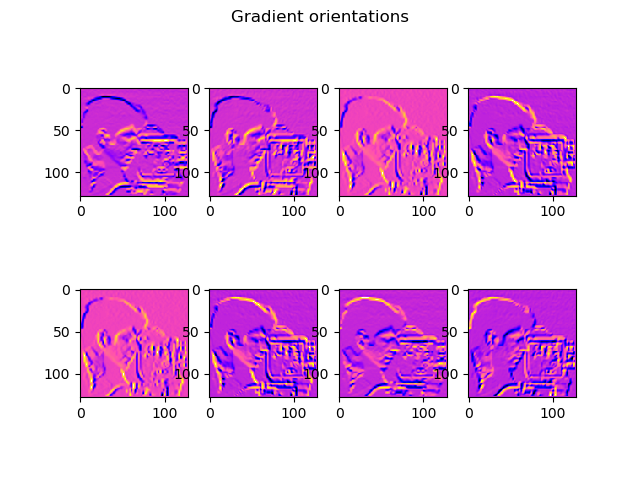

In [38]:
show_maps(gradient_orientations, title='Gradient orientations')

The convolved orientation maps for each ring:

<IPython.core.display.Javascript object>


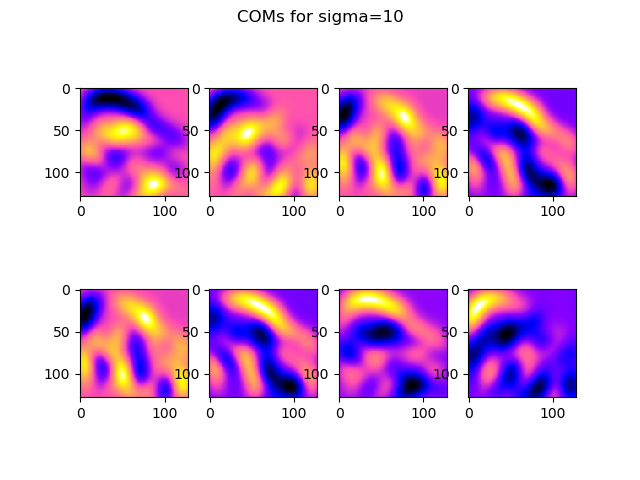

<IPython.core.display.Javascript object>


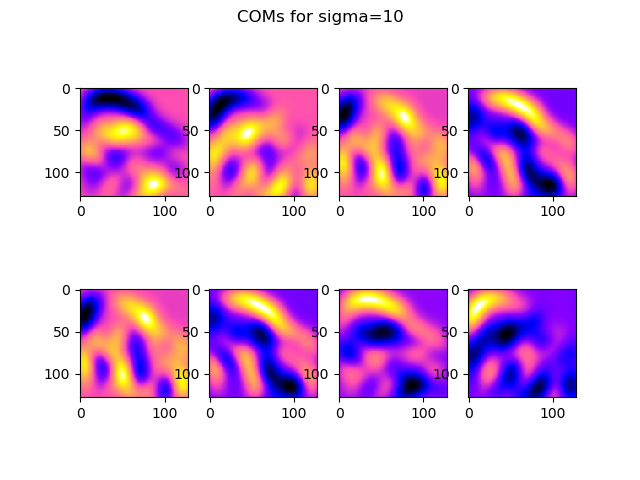

<IPython.core.display.Javascript object>


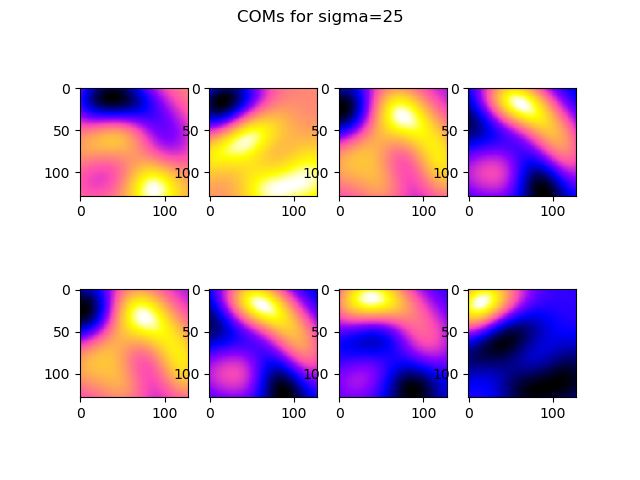

In [39]:
for i in range(len(SIGMAS)):
    show_maps(coms[i], title=f'COMs for sigma={SIGMAS[i]}')

### Resulting descriptor
Resulting descriptor vector is consists of $D_s$ elements:

In [40]:
print(descriptor)

[[ 0.26262959 -0.11514637 -0.42547115 -0.4865607  -0.26262959  0.11514637
   0.42547115  0.4865607  -0.12551109 -0.43098282 -0.48399067 -0.25348334
   0.12551109  0.43098282  0.48399067  0.25348334 -0.22971641 -0.47646458
  -0.44410626 -0.15159651  0.22971641  0.47646458  0.44410626  0.15159651
   0.07223024  0.40091931  0.49475529  0.29877032 -0.07223024 -0.40091931
  -0.49475529 -0.29877032  0.34351636  0.499804    0.36331324  0.0139985
  -0.34351636 -0.499804   -0.36331324 -0.0139985   0.4997298   0.34174055
  -0.01643568 -0.36498411 -0.4997298  -0.34174055  0.01643568  0.36498411
   0.48762676  0.42297114  0.11054476 -0.26663724 -0.48762676 -0.42297114
  -0.11054476  0.26663724  0.35871357  0.49994595  0.34831677 -0.00735165
  -0.35871357 -0.49994595 -0.34831677  0.00735165 -0.42043373 -0.10593393
   0.27062054  0.48864916  0.42043373  0.10593393 -0.27062054 -0.48864916
   0.20073248 -0.18187119 -0.45793719 -0.46574979 -0.20073248  0.18187119
   0.45793719  0.46574979 -0.4958511  -

## Next steps
From here we will compare descriptors with skimage implementations and test their invariancy to scale and rotation.